# Safety levels

NEN 8700 specifies a number of safety levels, which are essentially reliability indices that a construction must meet:

| Safety level | Assessment level |
|--------------|------------------|
| CC3          | 3.3              |
| CC2          | 2.5              |
| CC1b         | 1.8              |
| CC1a         | 1.8              |


In this example, we will show how to apply the safety levels to assess the bearing capacity of a pile. 

### Define model

First, let's import the necessary classes:

In [ ]:
from probabilistic_library import UncertaintyProject, DistributionType, UncertaintyMethod, StandardNormal

We use the Koppejan method to calculate the bearing capacity of a pile ($p$).

For this example, we assume there are two soil layers: the top layer is clay, and the bottom layer is sand. The surface level is at $0$ m+NAP. The soil has the following characteristics:

| Parameter | Description                          |
|-----------|--------------------------------------|
| z         | Depth at which the sand layer starts |
| q_clay    | CPT resistance in clay layer         |
| q_sand    | CPT resistance in sand layer         |
    
The pile has the following characteristics:

| Parameter | Description         |
|-----------|---------------------|
| D         | Diameter of the pile|
| L         | Length of the pile  |

The Koppejan method is implemented in the following function:

In [2]:
from utils.models import get_bearing_capacity

The bearing capacity of a pile is compared with the applied load, resulting in a unity check value (UC). A UC value greater than $1.0$ indicates failure, meaning the load exceeds the bearing capacity of the pile.

In [3]:
def get_unity_check(load, z, q_clay, q_sand, D, L):
    p = get_bearing_capacity(z, q_clay, q_sand, D, L)
    uc = load / p

    return uc

### Uncertainty analysis

The goal is to calculate the UC values at the safety levels. To achieve this, we conduct a uncertainty analysis. We begin by creating a uncertainty project and defining the model:

In [ ]:
project = UncertaintyProject()
project.model = get_unity_check

project.model.print()

Model get_unity_check:
Input parameters:
  load
  z
  q_clay
  q_sand
  D
  L
Output parameters:
  uc


### Assign variables

The following values and uncertainties are applied to the variables. The load is derived from a design value and is recalculated as a stochastic variable, as we want to perform a full probabilistic calculation.

In [5]:
project.variables["D"].distribution = DistributionType.normal
project.variables["D"].mean = 0.2
project.variables["D"].deviation = 0.04
project.variables["D"].truncated = True
project.variables["D"].minimum = 0.0
project.variables["D"].maximum = 1.0

project.variables["L"].distribution = DistributionType.normal
project.variables["L"].mean = 12.0
project.variables["L"].deviation = 0.8

project.variables["z"].distribution = DistributionType.normal
project.variables["z"].mean = 10.0
project.variables["z"].deviation = 0.2

project.variables["q_sand"].distribution = DistributionType.log_normal
project.variables["q_sand"].mean = 500.0
project.variables["q_sand"].deviation = 50.0

project.variables["q_clay"].distribution = DistributionType.log_normal
project.variables["q_clay"].mean = 25000.0
project.variables["q_clay"].deviation = 400.0

project.variables["load"].distribution = DistributionType.gumbel
project.variables["load"].design_quantile = 0.95
project.variables["load"].design_factor = 1.0
project.variables["load"].variation = 0.1
project.variables["load"].design_value = 100000.0

print(f"Load = {project.variables["load"].mean} +- {project.variables["load"].deviation}")

Load = 84275.78591160773 +- 8427.578591160775


### Perform calculation 

We perform the uncertainty analysis using `crude_monte_carlo` method:

In [ ]:
project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.maximum_samples = 10000
project.run()
uc_mc = project.stochast

Let's plot the results:

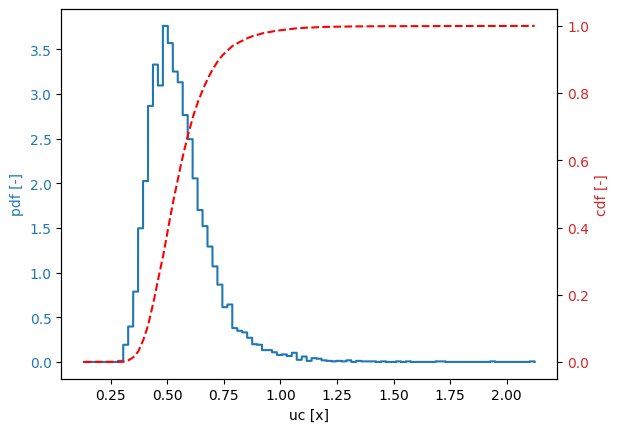

In [7]:
uc_mc.plot()

Next, we derive the values of UC, which correspond to the predefined safety levels. If the UC value for a given safety level is greater than $1.0$, then that safety level is not met.

In [8]:
safety_levels = [1.8, 2.5, 3.3]
safety_levels_txt = ["CC1b", "CC2 ", "CC3 "]

def check_sl(uc, safety_levels, safety_levels_txt):

    for idx, sl in enumerate(safety_levels):
        p = StandardNormal.get_p_from_u(sl)
        uc_sl = uc.get_quantile(p)
        print (f"Safety level ({safety_levels_txt[idx]}):  {sl} => UC = {uc_sl}")

check_sl(uc_mc, safety_levels, safety_levels_txt)

Safety level (CC1b):  1.8 => UC = 0.8564457238247964
Safety level (CC2 ):  2.5 => UC = 1.0979807121952416
Safety level (CC3 ):  3.3 => UC = 1.6925889446516016



We see that the pile construction meets only the safety level CC1b. Safety levels CC2 and CC3 are not met.

### Alternative methods

We can also apply other uncertainty methods: `form`, `importance_sampling` or `directional_sampling`. 

For `directional_sampling`, it is neceessary to predefine the quantiles in which we are interested (the reliability index $3.3$ is not calculated well, therefore another value is used).

Variable uc:
  distribution = cdf_curve
Definition:
  beta[0.1688807669065691] = -7.992568113194502
  beta[0.17745759743881048] = -7.4937740078990975
  beta[0.18679484884503075] = -6.994844414882844
  beta[0.19699421790269334] = -6.495786337916077
  beta[0.20817588555240882] = -5.996607232674467
  beta[0.2204828196736307] = -5.497314979893966
  beta[0.23408631629052495] = -4.997917836502923
  beta[0.24919321075672649] = -4.49842435563578
  beta[0.2660553706070524] = -3.998843264684347
  beta[0.2849823517443602] = -3.4991832908002816
  beta[0.3063585130599929] = -2.999452929049303
  beta[0.3306665333159004] = -2.499660166835017
  beta[0.3585203205572849] = -1.9998122225068986
  beta[0.3907120456423308] = -1.4999154489818052
  beta[0.42828103177142995] = -0.9999757297401287
  beta[0.4726176053980603] = -0.5
  beta[0.5256250596506683] = 0.0
  beta[0.5899500869163118] = 0.5
  beta[0.6694642912240717] = 0.9999686419463066
  beta[0.7700127216583125] = 1.499847391297994
  beta[0.9009021968553

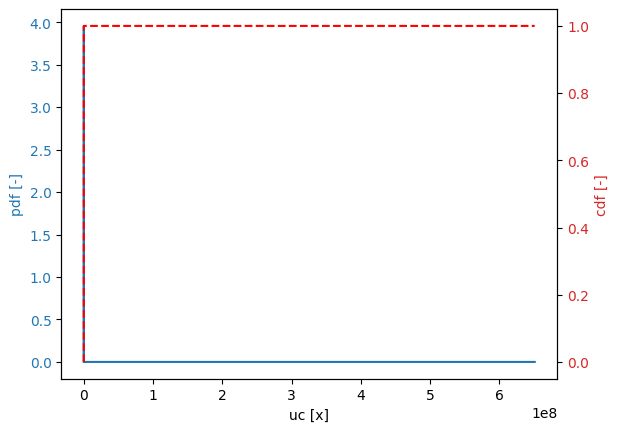

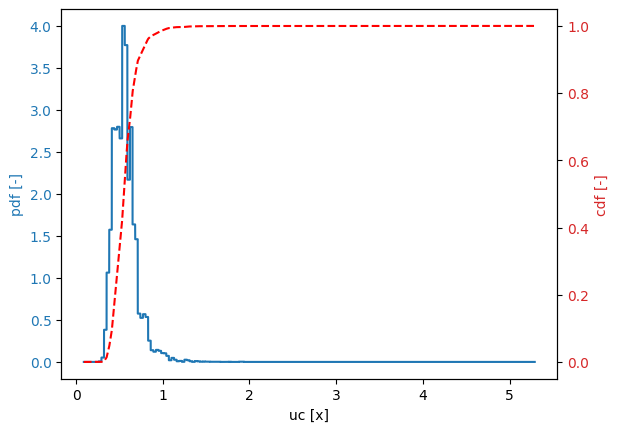

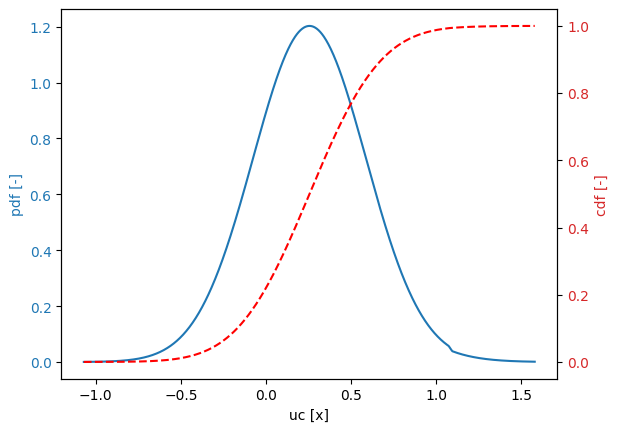

In [ ]:
project.settings.uncertainty_method = UncertaintyMethod.form
project.run()
project.result.print()

print(project.settings.uncertainty_method)
check_sl(project.result.variable, safety_levels, safety_levels_txt)
project.result.plot()

project.settings.uncertainty_method = UncertaintyMethod.importance_sampling
project.settings.maximum_samples = 1000
project.settings.stochast_settings["D"].start_value = -0.5
project.settings.stochast_settings["load"].start_value = 0.5
project.run()
project.result.print()
print(' ')
print(project.settings.uncertainty_method)
check_sl(project.result.variable, safety_levels, safety_levels_txt)
project.result.plot()

project.settings.uncertainty_method = UncertaintyMethod.directional_sampling
project.settings.maximum_directions = 1000
project.settings.variation_coefficient = 0.01
project.settings.quantiles.append(StandardNormal.get_p_from_u(1.8))
project.settings.quantiles.append(StandardNormal.get_p_from_u(2.5))
project.settings.quantiles.append(StandardNormal.get_p_from_u(3.0))

safety_levels_ds = [1.8, 2.5, 3.0]
project.run()
project.result.print()
print(' ')
print(project.settings.uncertainty_method)
check_sl(project.result.variable, safety_levels_ds, safety_levels_txt)
project.result.plot()